# Self-supervised and multi-modal representation Learning: Notebook 3

Here we will align the image and light curve representations with contrastive learning. Optionally, we can use the light curve encoder we trained previously.

## Multi-modal contrastive learning

### Light curve encoding via masked self-supervised learning

In [249]:
import os, sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
from einops import rearrange

from IPython.display import Image as IPImage

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load host images and inspect shape.

In [250]:
dir_host_imgs = "../data/ZTFBTS/hostImgs/"
host_imgs = []

for filename in os.listdir(dir_host_imgs):
    file_path = os.path.join(dir_host_imgs, filename)
    if file_path.endswith(".png"):
        host_img = Image.open(file_path).convert('RGB')
        host_img = np.asarray(host_img)
        host_imgs.append(host_img)

host_imgs = np.array(host_imgs)

host_imgs = torch.from_numpy(host_imgs).float()
host_imgs = rearrange(host_imgs, 'b h w c -> b c h w')

# Normalize
host_imgs /= 255.0

Load light curves and pre-process them just like in the previous notebook.

In [251]:
dir_light_curves = "../data/ZTFBTS/light-curves/"

def open_light_curve_csv(filename):
    file_path = os.path.join(dir_light_curves, filename)
    df = pd.read_csv(file_path)
    return df

light_curve_df = open_light_curve_csv("ZTF18aailmnv.csv")
light_curve_df.head()

,time,mag,magerr,band
0,58312.219097,20.132299,0.252360,R
1,58319.205984,18.713728,0.104188,g
2,58319.224942,18.808235,0.092660,R
3,58320.174525,18.467438,0.093920,g
4,58324.179444,18.514769,0.117073,R


In [252]:
band = 'R'
n_max_obs = 100

lightcurve_files = os.listdir(dir_light_curves)

# For entries with > n_max_obs observations, randomly sample n_max_obs observations (hmjd, mag, and magerr with same sample) from the light curve
# Pad the entries to n_max_obs observations with zeros and create a mask array
mask_list = []
mag_list = []
magerr_list = []
time_list = []

for filename in tqdm(lightcurve_files):
    if filename.endswith(".csv"):
        light_curve_df = open_light_curve_csv(filename)
        
        # Make sure the csv contains 'time', 'mag', 'magerr', and 'band' columns
        if not all(col in light_curve_df.columns for col in ['time', 'mag', 'magerr', 'band']):
            continue
        
        bands = light_curve_df['band'].unique()
        df_band = light_curve_df[light_curve_df['band'] == band]
                
        if len(df_band['mag']) > n_max_obs:
            mask = np.ones(n_max_obs, dtype=bool)
            mask_list.append(mask)
            indices = np.random.choice(len(df_band['mag']), n_max_obs)
            time = df_band['time'].values[indices]
            mag = df_band['mag'].values[indices]
            magerr = df_band['magerr'].values[indices]
        else:
            mask = np.zeros(n_max_obs, dtype=bool)
            mask[:len(df_band['mag'])] = True
            mask_list.append(mask)

            # Pad the arrays with zeros
            time = np.pad(df_band['time'], (0, n_max_obs - len(df_band['time'])), 'constant')
            mag = np.pad(df_band['mag'], (0, n_max_obs - len(df_band['mag'])), 'constant')
            magerr = np.pad(df_band['magerr'], (0, n_max_obs - len(df_band['magerr'])), 'constant')
            
        time_list.append(time)
        mag_list.append(mag)
        magerr_list.append(magerr)

time_ary = np.array(time_list)
mag_ary = np.array(mag_list)
magerr_ary = np.array(magerr_list)
mask_ary = np.array(mask_list)

100%|██████████| 5170/5170 [00:04<00:00, 1288.10it/s]


In [253]:
# Inspect shapes
time_ary.shape, mag_ary.shape, magerr_ary.shape, mask_ary.shape

((5170, 100), (5170, 100), (5170, 100), (5170, 100))

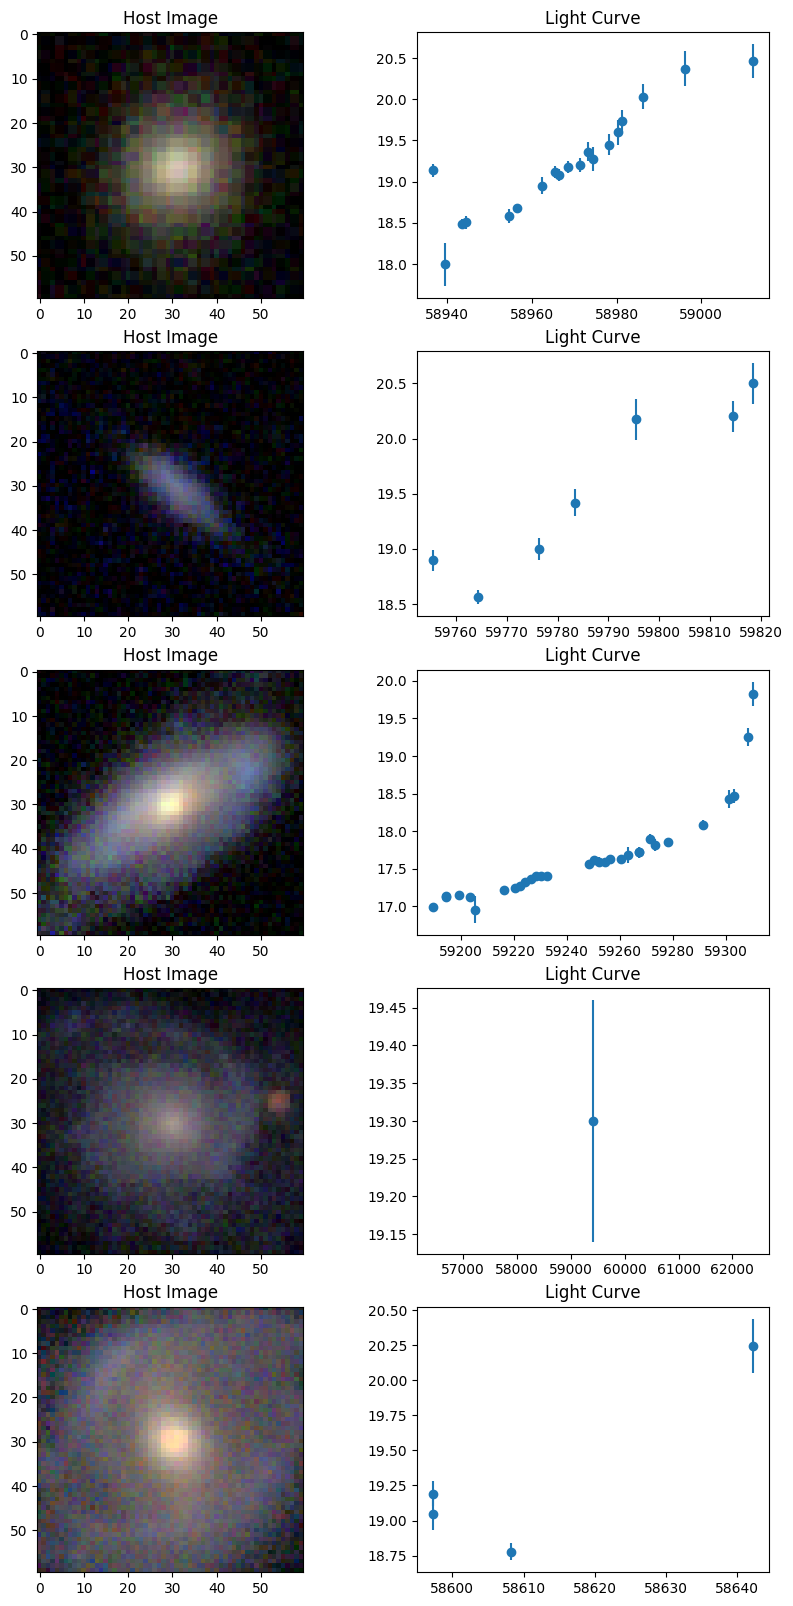

In [312]:
# Plot some corresponding light curves and host images (in two columns)
n_rows = 5
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20))

for i in range(n_rows):
    axs[i, 0].imshow(host_imgs[i].permute(1, 2, 0))
    axs[i, 0].set_title("Host Image")
    axs[i, 1].errorbar(time_ary[i][mask_ary[i]], mag_ary[i][mask_ary[i]], yerr=magerr_ary[i][mask_ary[i]], fmt='o')
    axs[i, 1].set_title("Light Curve")

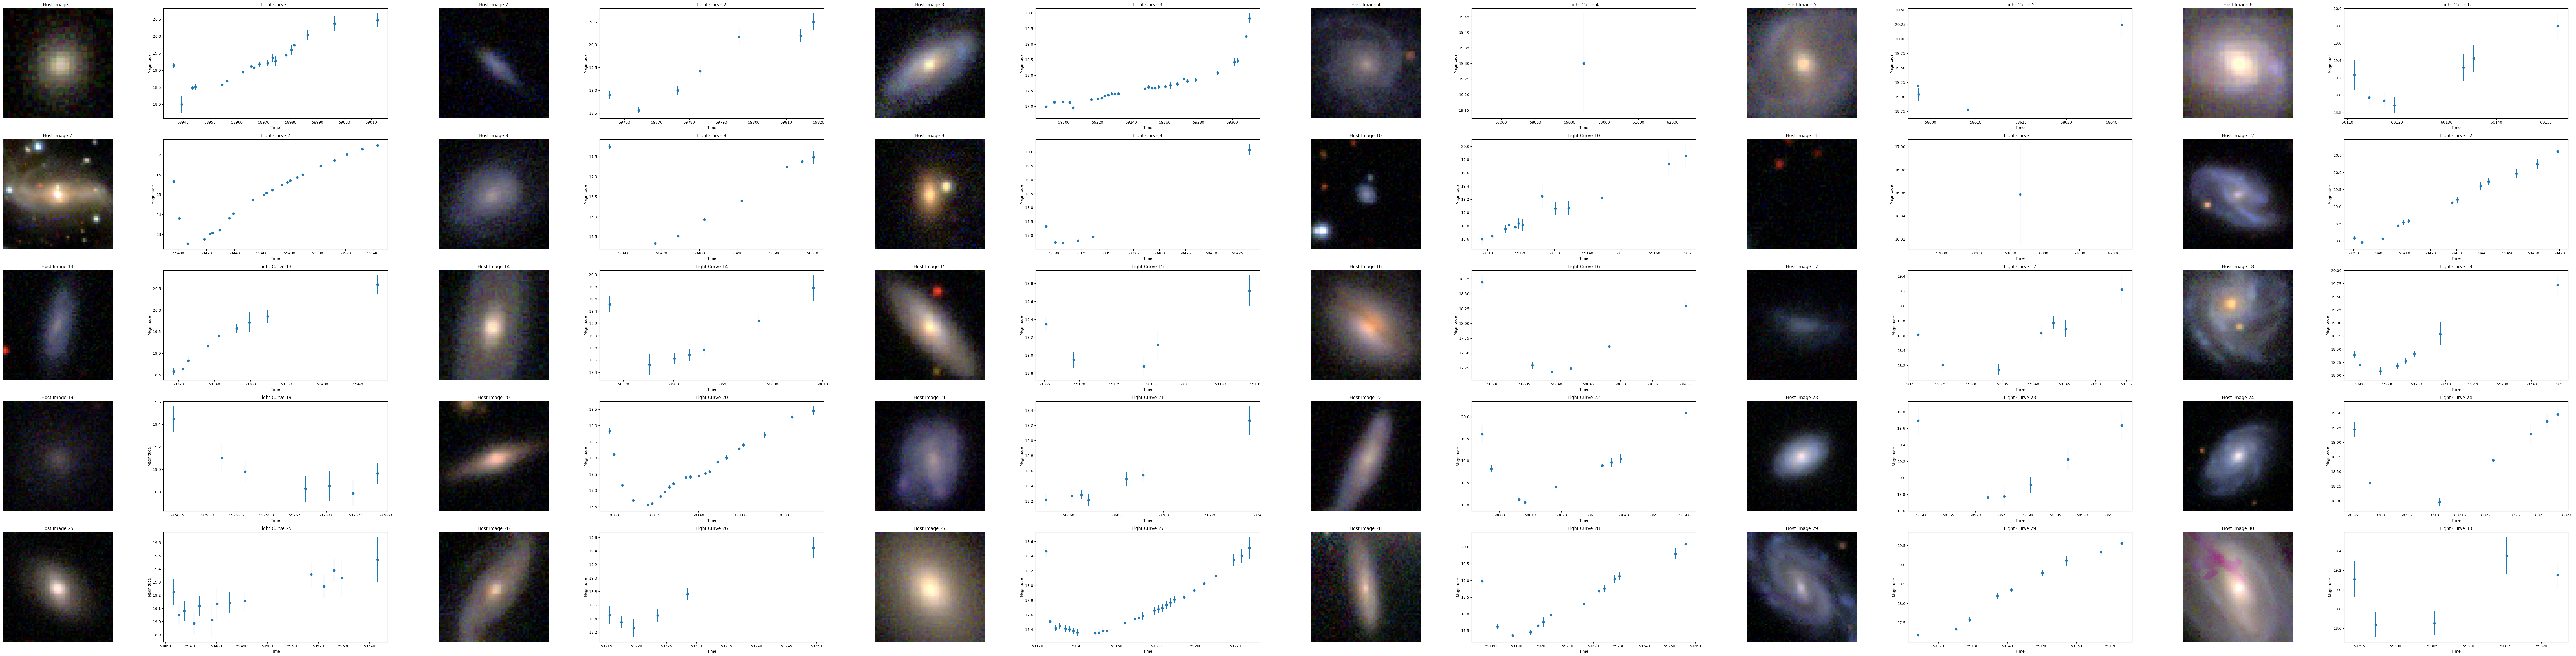

In [321]:
# Adjusting the layout to have more columns for pairs
# Assuming we want to display 12 columns, that's 6 pairs of images and light curves per row

n_pairs_per_row = 6
n_rows = 5  # Assuming we still have 5 rows of data

# Adjusting the number of columns
n_cols = n_pairs_per_row * 2  # Two columns per pair

# Creating a new big grid layout for the plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(100, 25))

for i in range(n_rows):
    for j in range(n_pairs_per_row):
        # Calculating the index for each unique data pair
        index = i * n_pairs_per_row + j

        # Plotting unique host images
        img_col = j * 2  # Column index for image
        axs[i, img_col].imshow(host_imgs[index].permute(1, 2, 0))
        axs[i, img_col].set_title(f"Host Image {index+1}")
        axs[i, img_col].axis('off')  # Turn off axis for images

        # Plotting unique light curves
        lc_col = img_col + 1  # Column index for light curve
        axs[i, lc_col].errorbar(time_ary[index][mask_ary[index]], 
                                mag_ary[index][mask_ary[index]], 
                                yerr=magerr_ary[index][mask_ary[index]], 
                                fmt='o')
        axs[i, lc_col].set_title(f"Light Curve {index+1}")
        axs[i, lc_col].set_xlabel("Time")
        axs[i, lc_col].set_ylabel("Magnitude")

plt.tight_layout()
plt.savefig("./assets/banner.png")

Looks good so far!

### Image encoder

Out host images are pretty simple 60x60 images. Let's try a [ConvMixer](https://arxiv.org/abs/2201.09792) architecture.

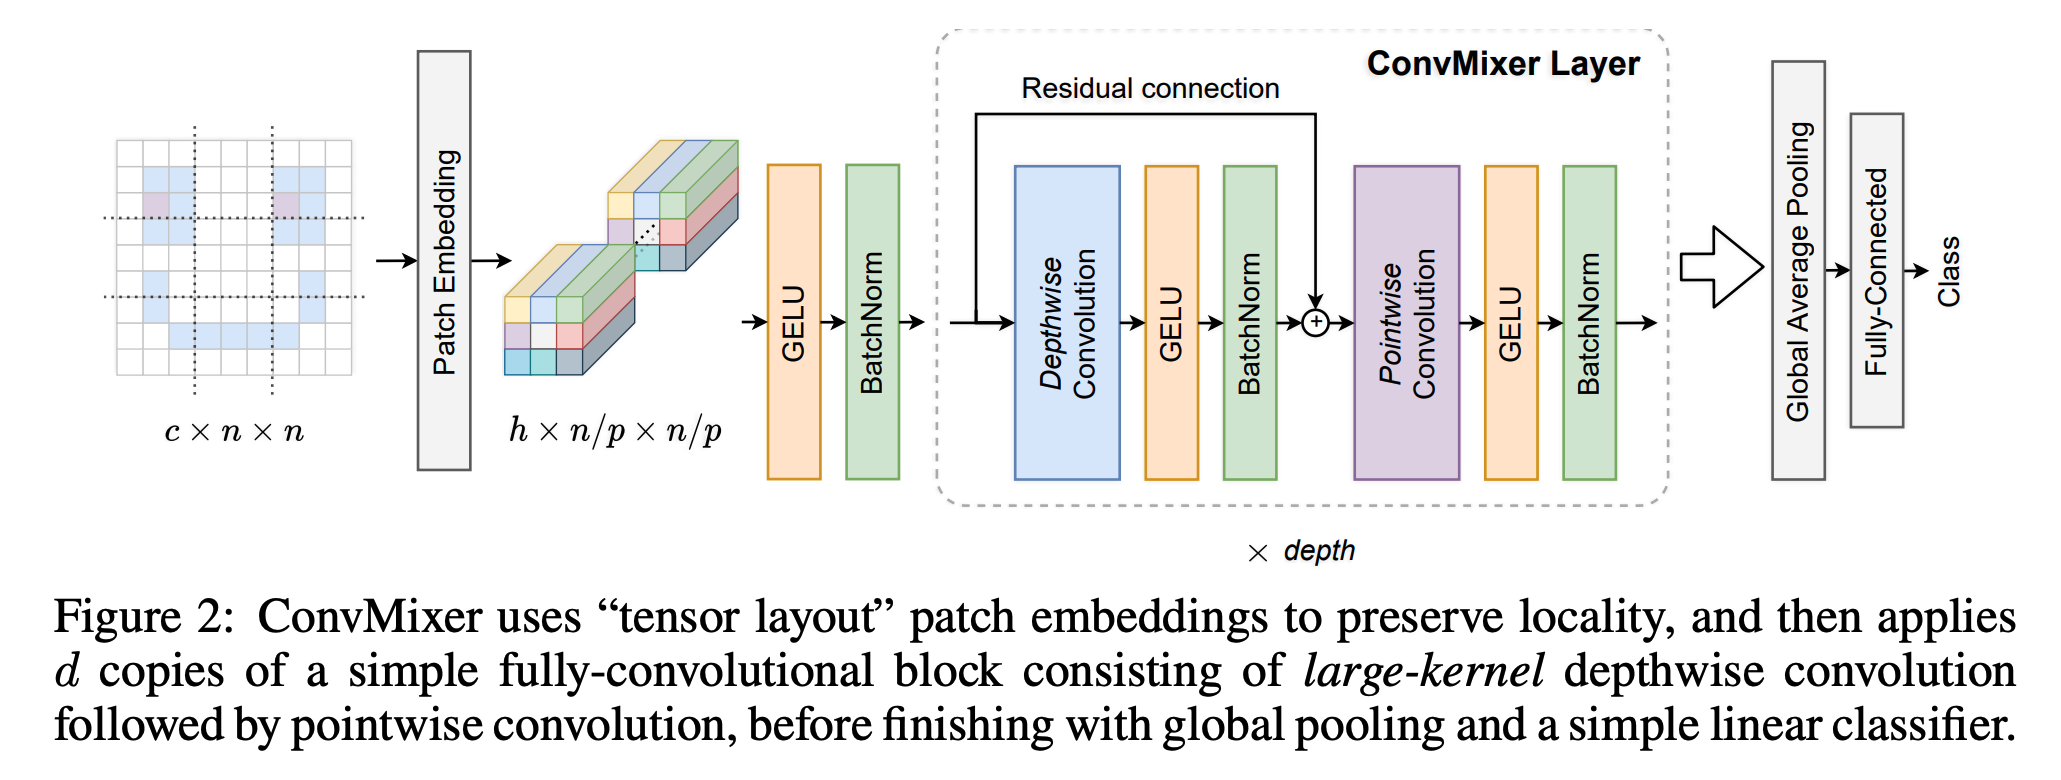

In [255]:
# From https://arxiv.org/pdf/2201.09792.pdf
IPImage(filename='assets/convmixer.png', width=1024)

In [256]:
import torch
import torch.nn as nn

In [257]:
class Residual(nn.Module):
    """
    A residual block that adds the input to the output of a function.
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        # Apply the function and add the input to the result
        return self.fn(x) + x
    

class ConvMixer(nn.Module):
    """
    ConvMixer model, a simple and efficient convolutional neural network.
    """
    def __init__(self, dim, depth, channels=1, kernel_size=5, patch_size=8, n_out=128):
        super(ConvMixer, self).__init__()

        # Initial convolution layer
        self.net = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size, bias=False),
            nn.GELU(),
            nn.BatchNorm2d(dim),
        )

        # Adding depth number of ConvMixer layers
        for _ in range(depth):
            self.net.append(nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            ))

        # Projection head
        self.projection = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(dim, 1024),
            nn.GELU(),
            nn.Linear(1024, n_out)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.net(x)
        x = self.projection(x)
        return x

In [258]:
convmixer = ConvMixer(dim=4, depth=40, channels=3, kernel_size=4, patch_size=2, n_out=128)
convmixer(host_imgs[:2])

tensor([[-0.1156,  0.0153, -0.0892, -0.1092, -0.0107, -0.1964,  0.0004, -0.0296,
          0.0268,  0.0479,  0.0046, -0.1558,  0.1382,  0.0069,  0.1045, -0.0297,
         -0.1357,  0.0788, -0.0361,  0.0600, -0.0109,  0.0564,  0.1762, -0.0618,
         -0.0205,  0.0676, -0.1290,  0.0426, -0.0532,  0.0086,  0.0362, -0.1461,
         -0.0913,  0.0311, -0.0112, -0.0691, -0.0202,  0.0700, -0.0607, -0.1128,
          0.1895, -0.2550,  0.1803,  0.1787, -0.0934, -0.0727,  0.0855, -0.0947,
          0.0623, -0.2830,  0.0457,  0.0721,  0.0326,  0.0397,  0.0085,  0.0130,
         -0.0605, -0.1437,  0.0120,  0.0596,  0.0819, -0.0710, -0.1133, -0.0035,
          0.0626,  0.0879,  0.1116,  0.1549, -0.0278,  0.1133,  0.1948,  0.0421,
         -0.0224, -0.1574,  0.0210, -0.1341,  0.1071,  0.0652, -0.0144, -0.0079,
          0.0558,  0.0516,  0.0109,  0.0141,  0.0939, -0.0260,  0.1020, -0.1171,
          0.0948,  0.0510,  0.1549, -0.0779,  0.0262,  0.1356, -0.1198, -0.0647,
          0.0602, -0.0572,  

### Lightcurve encoder

Similar encoder architecture as before. Try to see if you can transfer the transformer weights from the previous notebooks and potentially freeze them, and what effect this has on the downstream task.

In [260]:
import math
from models.transformer_utils import Transformer

class TimePositionalEncoding(nn.Module):

    def __init__(self, d_emb):
        """
        Inputs
            d_model - Hidden dimensionality.
        """
        super().__init__()
        self.d_emb = d_emb

    def forward(self, t):
        pe = torch.zeros(t.shape[0], t.shape[1], self.d_emb).to(t.device)  # (B, T, D)
        div_term = torch.exp(torch.arange(0, self.d_emb, 2).float() * (-math.log(10000.0) / self.d_emb))[None, None, :].to(t.device)  # (1, 1, D / 2)
        t = t.unsqueeze(2)  # (B, 1, T)
        pe[:, :, 0::2] = torch.sin(t * div_term)  # (B, T, D / 2)
        pe[:, :, 1::2] = torch.cos(t * div_term)  # (B, T, D / 2)
        return pe  # (B, T, D)

class TransformerWithTimeEmbeddings(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, n_out, **kwargs):
        """
        :param n_out: Number of output emedding.
        :param kwargs: Arguments for Transformer.
        """
        super().__init__()
        
        self.embedding_mag = nn.Linear(in_features=1, out_features=kwargs['emb'])
        self.embedding_t = TimePositionalEncoding(kwargs['emb'])
        self.transformer = Transformer(**kwargs)

        self.projection = nn.Linear(kwargs['emb'], n_out)

    def forward(self, x, t, mask=None):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        t = t - t[:, 0].unsqueeze(1)
        t_emb = self.embedding_t(t)
        x = self.embedding_mag(x) + t_emb
        x = self.transformer(x, mask)  # (B, T, D)
        
        # Zero out the masked values
        x = x * mask[:, :, None]

        # Max pool
        x = x.max(dim=1)[0]
        
        x = self.projection(x)
        return x

transformer = TransformerWithTimeEmbeddings(n_out=128, emb=128, heads=1, depth=1)

In [261]:
# Time and mag tensors
time = torch.from_numpy(time_ary).float()
mag = torch.from_numpy(mag_ary).float()
mask = torch.from_numpy(mask_ary).bool()

In [262]:
# Pass a batch through
transformer(mag[:4][..., None], time[:4], mask[:4]).shape

torch.Size([4, 128])

### Create dataset

In [277]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.05
batch_size = 128
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(host_imgs, mag, time, mask)

dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

### Contrastive-style losses

In [278]:
import torch.nn.functional as F
import pytorch_lightning as pl

The standard CLIP architecture uses a bidirection (symmetric between modalities, e.g. image and text) version of the so-called SimCLR loss to compute alignment between image and light curve representations.
$$\mathcal{L}_\mathrm{CLIP}=-\frac{1}{2|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|}\left(\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_i \cdot y_j}}+\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_j \cdot y_i}}\right)$$

The standard CLIP loss can be quite unstable due to the small number of positive pairs and large number of negative pairs in a batch. It can also often require very large batch sizes to work well (I know those sound contradictory 🙃). There are many proposed ways of overcoming this, e.g. see https://lilianweng.github.io/posts/2021-05-31-contrastive/ for some approaches. 

In addition to theh sofrmax-based loss, we'll also try a sigmoid loss, from https://arxiv.org/abs/2303.15343:
$$\mathcal{L}_\mathrm{SigLIP}=-\frac{1}{|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|} \sum_{j=1}^{|\mathcal{B}|} \log \frac{1}{1+e^{z_{i j}\left(-t\, {x}_i \cdot {y}_j+b\right)}}$$
where $x_i$ and $y_j$ are the normalized image and light curve representations, respectively, and $z_{ij}$ is a binary indicator of whether the image and light curve are a match or not.

Let's implement these two.

In [279]:
def clip_loss(image_embeddings, text_embeddings, temperature=1):
    """ Standard softmax-based CLIP loss, adapted from https://wandb.ai/manan-goel/coco-clip/reports/Implementing-CLIP-With-PyTorch-Lightning--VmlldzoyMzg4Njk1
    """
    
    log_softmax = nn.LogSoftmax(dim=1)

    logits = (text_embeddings @ image_embeddings.T) / temperature
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = F.softmax((images_similarity + texts_similarity) / 2 * temperature, dim=-1)
    images_loss = (-targets.T * log_softmax(logits.T)).sum(1)
    texts_loss = (-targets * log_softmax(logits)).sum(1)
    return (images_loss + texts_loss) / 2.0

def sigmoid_loss(image_embeds, text_embeds, logit_scale=1., logit_bias=2.73):
    """ Sigmoid-based CLIP loss, from https://arxiv.org/abs/2303.15343
    """

    bs = text_embeds.shape[0]
    
    labels = 2 * torch.eye(bs) - torch.ones((bs, bs))
    labels = labels.to(text_embeds.device)

    logits = text_embeds @ image_embeds.t() * logit_scale + logit_bias
    logits = logits.to(torch.float64)
    
    positive_loss = -torch.mean(torch.log(torch.sigmoid(labels * logits)))
    
    shifted_image_embeds = torch.roll(image_embeds, 1, dims=0)
    negative_logits = text_embeds @ shifted_image_embeds.t() * logit_scale + logit_bias    
    negative_loss = -torch.mean(torch.log(1 - torch.sigmoid(negative_logits)))
    
    loss = positive_loss + negative_loss
    
    return loss

In [281]:
class LightCurveImageCLIP(pl.LightningModule):
    def __init__(self, 
                 enc_dim=128,
                 temperature=10.,
                 transformer_kwargs={"n_out":128, "emb":128, "heads":2, "depth":2}, 
                 conv_kwargs = {'dim': 16, 'depth': 8, 'channels': 3, 'kernel_size': 5, 'patch_size': 10, 'n_out': 128}, 
                 optimizer_kwargs={}, lr=1e-4):
        super().__init__()

        self.lr = lr
        self.optimizer_kwargs = optimizer_kwargs
        self.enc_dim = enc_dim

        # Make temperature and logit bias a learnable parameter
        self.logit_scale = nn.Parameter(torch.tensor(math.log(temperature)), requires_grad=True)
        self.logit_bias = nn.Parameter(torch.tensor(-10.), requires_grad=True)

        # Encoders
        self.lightcurve_encoder = TransformerWithTimeEmbeddings(**transformer_kwargs)
        self.image_encoder = ConvMixer(**conv_kwargs)

        # Projection heads to common embedding space
        self.lightcurve_projection = nn.Linear(transformer_kwargs['n_out'], enc_dim)
        self.image_projection = nn.Linear(conv_kwargs['n_out'], enc_dim)

    def forward(self, x_img, x_lc, t_lc, mask_lc=None):
        
        # Light curve encoder
        x_lc = self.lightcurve_embeddings_with_projection(x_lc, t_lc, mask_lc)
        
        # Image encoder
        x_img = self.image_embeddings_with_projection(x_img)
    
        # Normalized embeddings
        return x_img, x_lc
    
    def image_embeddings_with_projection(self, x_img):
        """ Convenience function to get image embeddings with projection
        """
        x_img = self.image_encoder(x_img)
        x_img = self.image_projection(x_img)
        return x_img / x_img.norm(dim=-1, keepdim=True)
    
    def lightcurve_embeddings_with_projection(self, x_lc, t_lc, mask_lc=None):
        """ Convenience function to get light curve embeddings with projection
        """
        x_lc = x_lc[..., None]  # Add channel dimension
        x_lc = self.lightcurve_encoder(x_lc, t_lc, mask_lc)
        x_lc = self.lightcurve_projection(x_lc)
        return x_lc / x_lc.norm(dim=-1, keepdim=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}
    
    def training_step(self, batch, batch_idx):
        x_img, x_lc, t_lc, mask_lc = batch
        x_img, x_lc = self(x_img, x_lc, t_lc, mask_lc)
        # loss = sigmoid_loss(x_img, x_lc, self.logit_scale, self.logit_bias).mean()
        loss = clip_loss(x_img, x_lc, self.logit_scale).mean()
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x_img, x_lc, t_lc, mask_lc = batch
        x_img, x_lc = self(x_img, x_lc, t_lc, mask_lc)
        # loss = sigmoid_loss(x_img, x_lc, self.logit_scale, self.logit_bias).mean()
        loss = clip_loss(x_img, x_lc, self.logit_scale).mean()
        self.log("val_loss", loss, on_epoch=True)
        return loss

In [282]:
clip_model = LightCurveImageCLIP(temperature=5., lr=1e-3)

x_img, x_lc, t_lc, mask_lc = next(iter(train_loader))
x_img, x_lc = clip_model(x_img, x_lc, t_lc, mask_lc)

sigmoid_loss(x_img, x_lc, clip_model.logit_scale).mean()

tensor(5.9554, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [283]:
trainer = pl.Trainer(max_epochs=2, accelerator='cpu')
trainer.fit(model=clip_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type                          | Params
------------------------------------------------------------------------
0 | lightcurve_encoder    | TransformerWithTimeEmbeddings | 412 K 
1 | image_encoder         | ConvMixer                     | 159 K 
2 | lightcurve_projection | Linear                        | 16.5 K
3 | image_projection      | Linear                        | 16.5 K
------------------------------------------------------------------------
605 K     Trainable params
0         Non-trainable params
605 K     Total params
2.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## Downstream task: retrieval

Try your hand at various downstream tasks: compute embeddings over images, see if they are able to identify similar images/light curves better than the base model. See if the model has learned useful joint representations by trying retrieval across modalities (image to light curve and vice versa).

In [284]:
clip_model = clip_model.eval()

In [285]:
def cosine_similarity(a, b):
    a = a / a.norm(dim=-1, keepdim=True)
    b = b / b.norm(dim=-1, keepdim=True)
    
    return (a @ b.T).squeeze()

In [297]:
emb_host = clip_model.image_embeddings_with_projection(host_imgs[:1000])

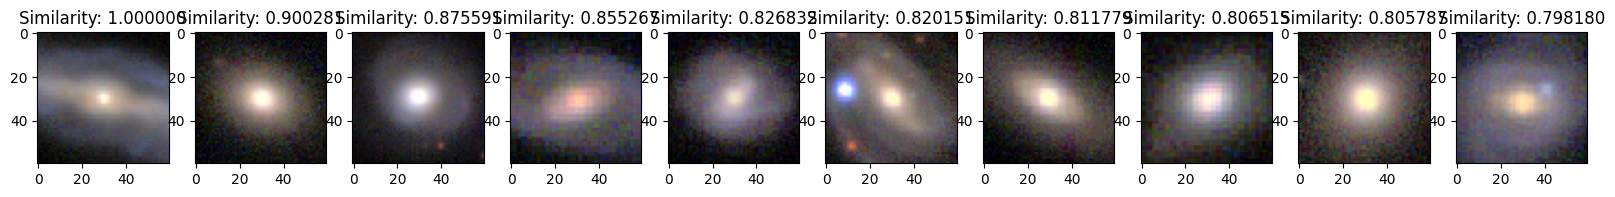

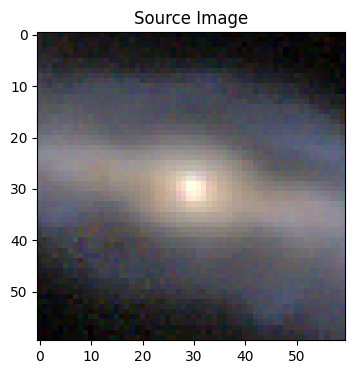

In [298]:
def plot_retrieved_im(idx_src):
        
    emb_src = clip_model.image_embeddings_with_projection(host_imgs[idx_src:idx_src + 1])

    # Compute cosine similarity between host images and source image
    cos_sim = cosine_similarity(emb_host, emb_src)

    # Get the top 10 most similar host images
    top_10_idx = torch.argsort(cos_sim, descending=True)[:10]

    # Plot the top 10 most similar host images in on row
    fig, axs = plt.subplots(1, 10, figsize=(20, 5))

    for i, idx in enumerate(top_10_idx):
        axs[i].imshow(host_imgs[idx].permute(1, 2, 0))
        axs[i].set_title(f"Similarity: {cos_sim[idx]:.6f}")

    # Plot the source image
    plt.figure(figsize=(4, 4))
    plt.imshow(host_imgs[idx_src].permute(1, 2, 0))
    plt.title("Source Image")

plot_retrieved_im(33)


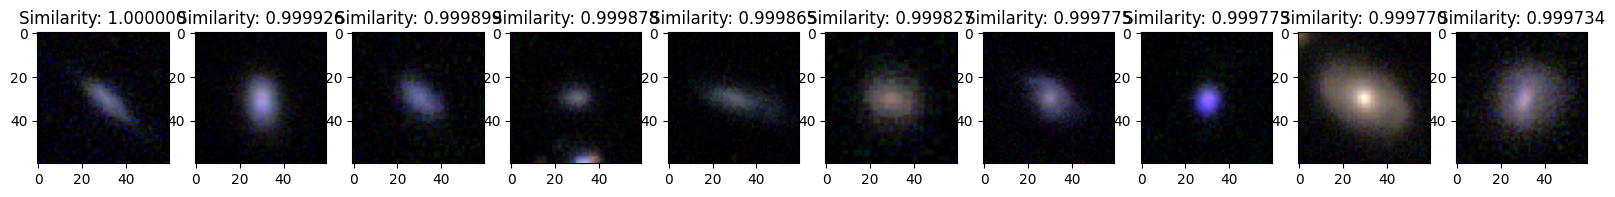

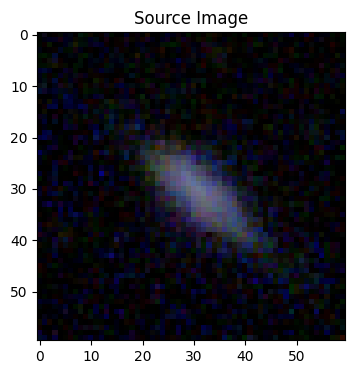

In [303]:
plot_retrieved_im(1)


Try the same thing with spectra.

In [304]:
# Spectra retrieval
emb_host = clip_model.lightcurve_embeddings_with_projection(mag[:1000], time[:1000], mask[:1000])

In [309]:
idx_src = 3488
emb_src = clip_model.lightcurve_embeddings_with_projection(mag[idx_src:idx_src + 1], time[idx_src:idx_src + 1], mask[idx_src:idx_src + 1])

Text(0.5, 1.0, 'Source Light Curve')

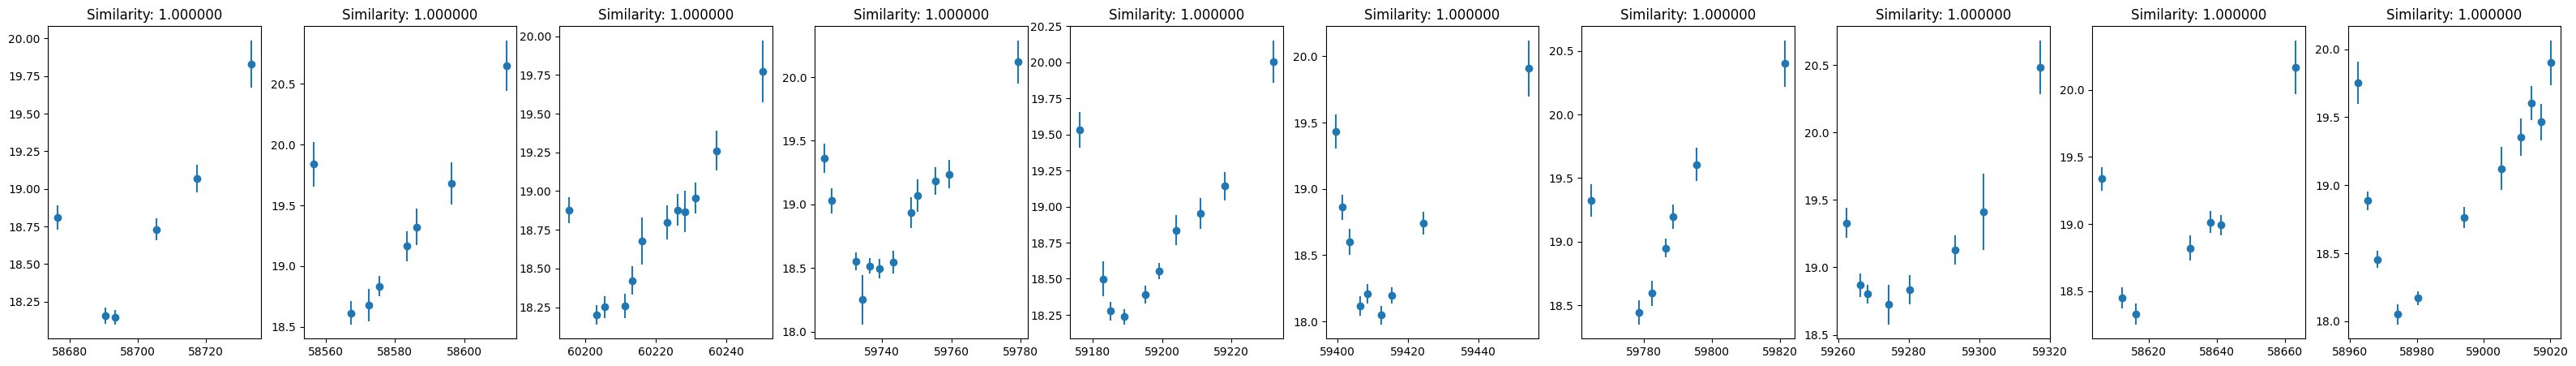

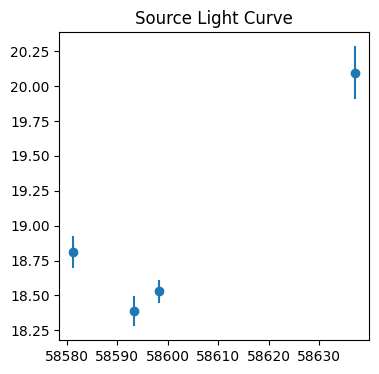

In [310]:
cos_sim = cosine_similarity(emb_host, emb_src)

# Plot the top 10 most similar light curves in a row

top_10_idx = torch.argsort(cos_sim, descending=True)[:10]

fig, axs = plt.subplots(1, 10, figsize=(40, 5))

for i, idx in enumerate(top_10_idx):
    axs[i].errorbar(time_ary[idx][mask_ary[idx]], mag_ary[idx][mask_ary[idx]], yerr=magerr_ary[idx][mask_ary[idx]], fmt='o')
    axs[i].set_title(f"Similarity: {cos_sim[idx]:.6f}")

# Plot the source light curve
plt.figure(figsize=(4, 4))
plt.errorbar(time_ary[idx_src][mask_ary[idx_src]], mag_ary[idx_src][mask_ary[idx_src]], yerr=magerr_ary[idx_src][mask_ary[idx_src]], fmt='o')
plt.title("Source Light Curve")

### Downstream tasks: fine-tuning and classification

Since we have access to a huge collection of light curves, we can also try to find interesting samples from this super noisy dataset based on the learned multimodal representations.

### Downstream tasks: fine-tuning and classification

Since we also have access to properties like redshift, we can train a regression head on top of the learned representations.

In [311]:
df_properties = pd.read_csv("../data/ZTFBTS/ZTFBTS_TransientTable.csv")
df_properties.head()

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,hostabs,hostcol,b,A_V
0,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,-20.72,0.64,27.562336,0.122
1,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,-22.70,1.06,59.641962,0.053
2,ZTF17aacldgo,SN2022zxv,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.072,-20.57,0.99,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.062,-22.16,0.91,34.174702,0.106
4,ZTF18aaaibml,SN2020buc,10:08:31.27,+09:14:23.0,909.80,r,18.2606,-17.70,69.73,27.302,42.428,SN II,0.0348,-19.67,0.38,47.637802,0.092
